In [1]:
import numpy as np
import matplotlib
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
from PIL import Image
from matplotlib.pyplot import imshow
#import nipy
#from nipy.labs.mask import compute_mask
from skimage import exposure, img_as_float
from skimage.exposure import rescale_intensity, adjust_gamma, equalize_adapthist
#from scipy import stats
#import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'DK61'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
MASK = os.path.join(DIR, 'preps','thumbnail_masked')
masks = sorted(os.listdir(MASK))
files = sorted(os.listdir(INPUT))

In [3]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_mask import trim_edges, get_binary_mask, fix_with_fill, equalized, fix_with_blob
from utilities.sqlcontroller import SqlController
sqlController = SqlController(animal)

In [4]:
bad = []
bads = ['{}.tif'.format(str(i).zfill(3)) for i in bad]
print(f'Need to manually fix {len(bads)} files or %{100*len(bads)/len(files)}')

Need to manually fix 0 files or %0.0


100%|██████████| 10/10 [00:00<00:00, 34.34it/s]


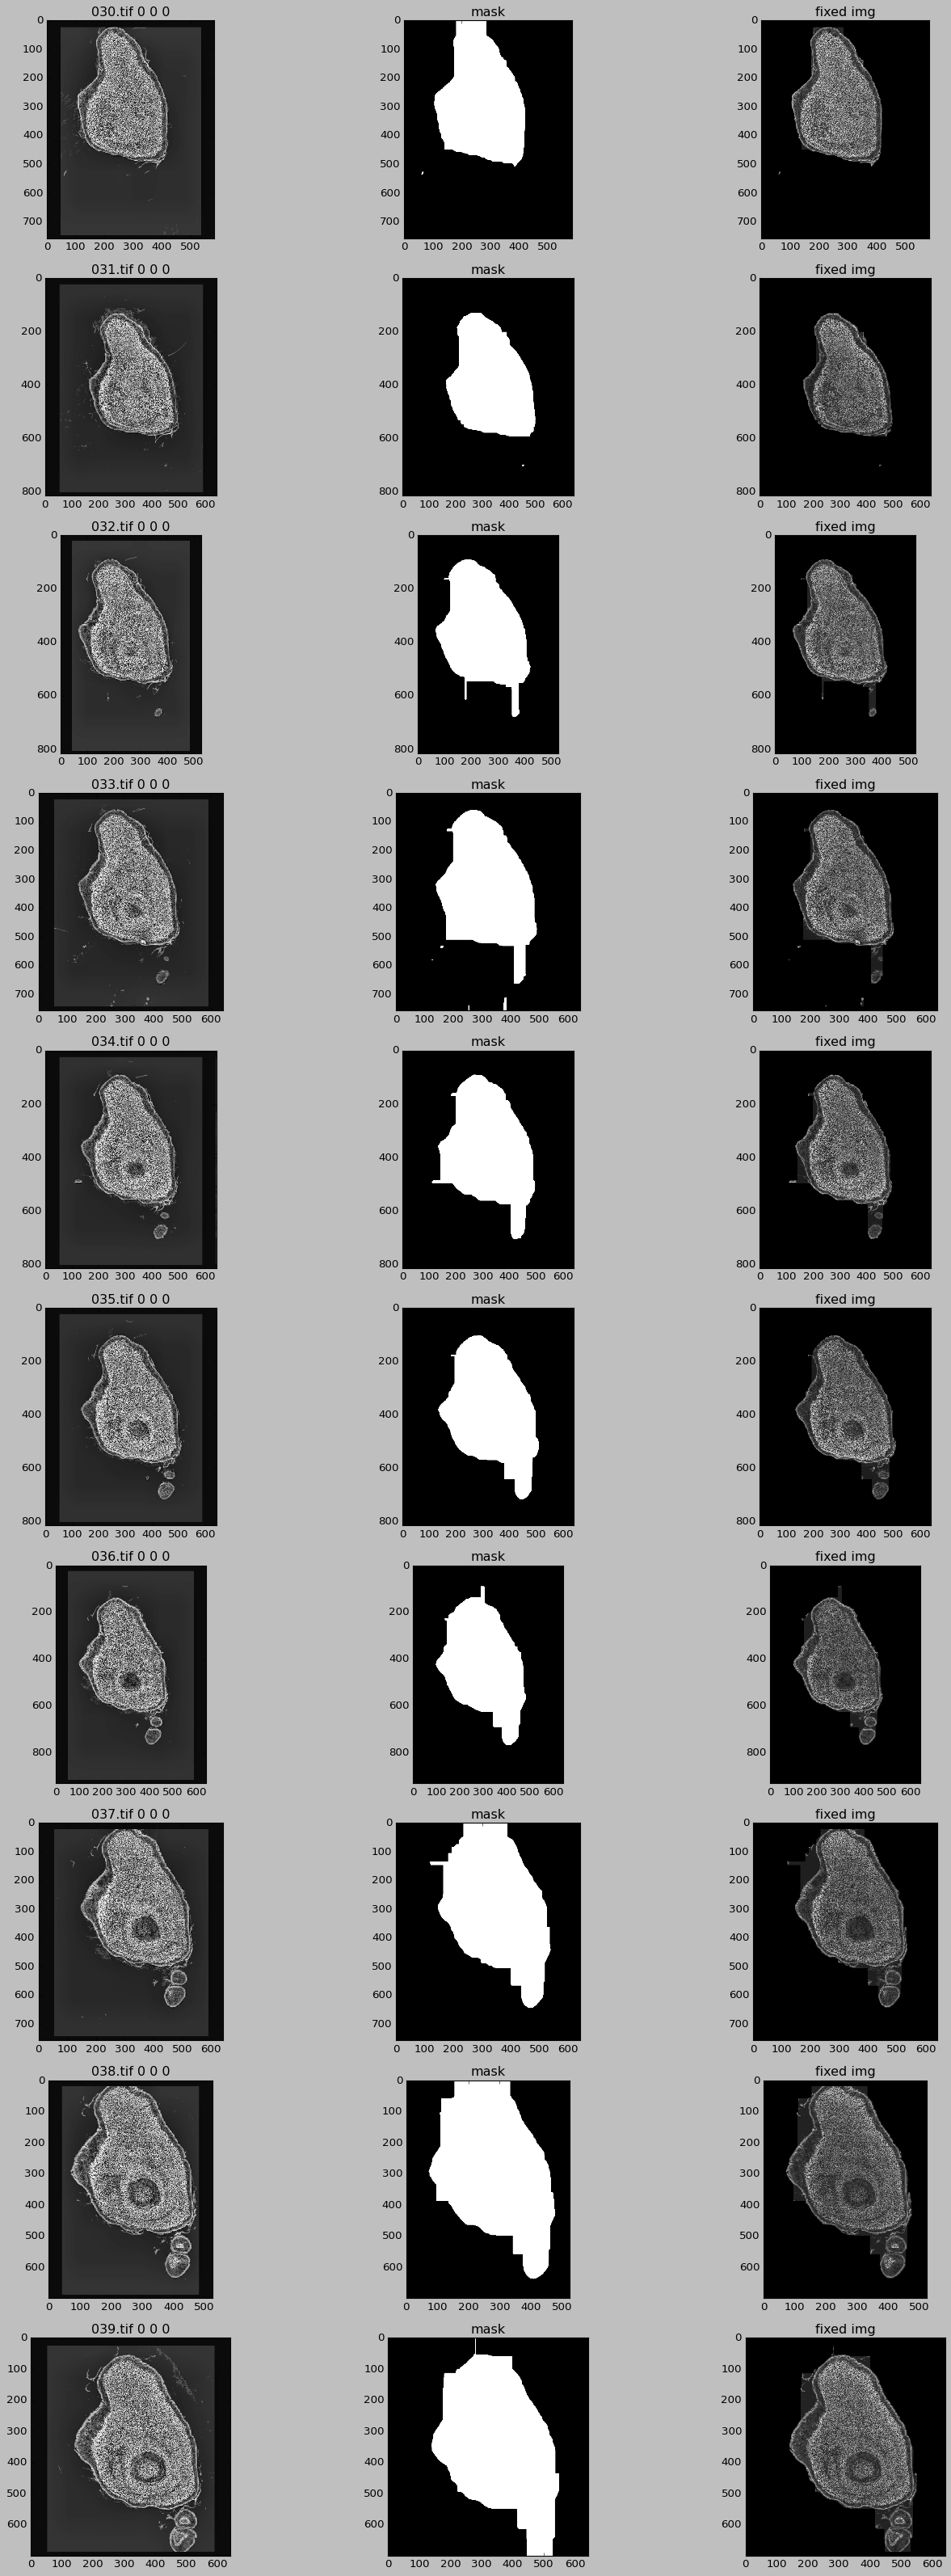

In [33]:
names = []
norms = []
masks = []
fixes = []
start, finish = (30,40)
lowVal, highVal, threshold = (0,0,0)

for file in tqdm(files[start:finish]):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    img = trim_edges(img)
    normed = equalized(img)
    img8 = (normed/256).astype('uint8')

    norms.append(normed)
    mask = get_binary_mask(img)
    fixed = cv2.bitwise_and(img, img, mask=mask)
    masks.append(mask)    
    name = f'{file} {round(lowVal)} {round(highVal)} {round(threshold)}'
    names.append(name)
    fixes.append(fixed)
    
fig, ax = plt.subplots(nrows=len(names), ncols=3, sharex=False, sharey=False)
plt.style.use('classic')
i = 0
for name, norm, mask, fixed in zip(names, norms, masks, fixes):
    ax[i,0].set_title(f'{name}')
    ax[i,0].imshow(norm, cmap="gray")
    ax[i,1].set_title('mask')
    ax[i,1].imshow(mask, cmap="gray")
    ax[i,2].set_title('fixed img')
    ax[i,2].imshow(fixed, cmap="gray")

    i += 1
fig.set_size_inches(np.array([18, 4 * len(names)]), forward=False)
plt.tight_layout()
plt.show()

100%|██████████| 10/10 [00:00<00:00, 38.07it/s]


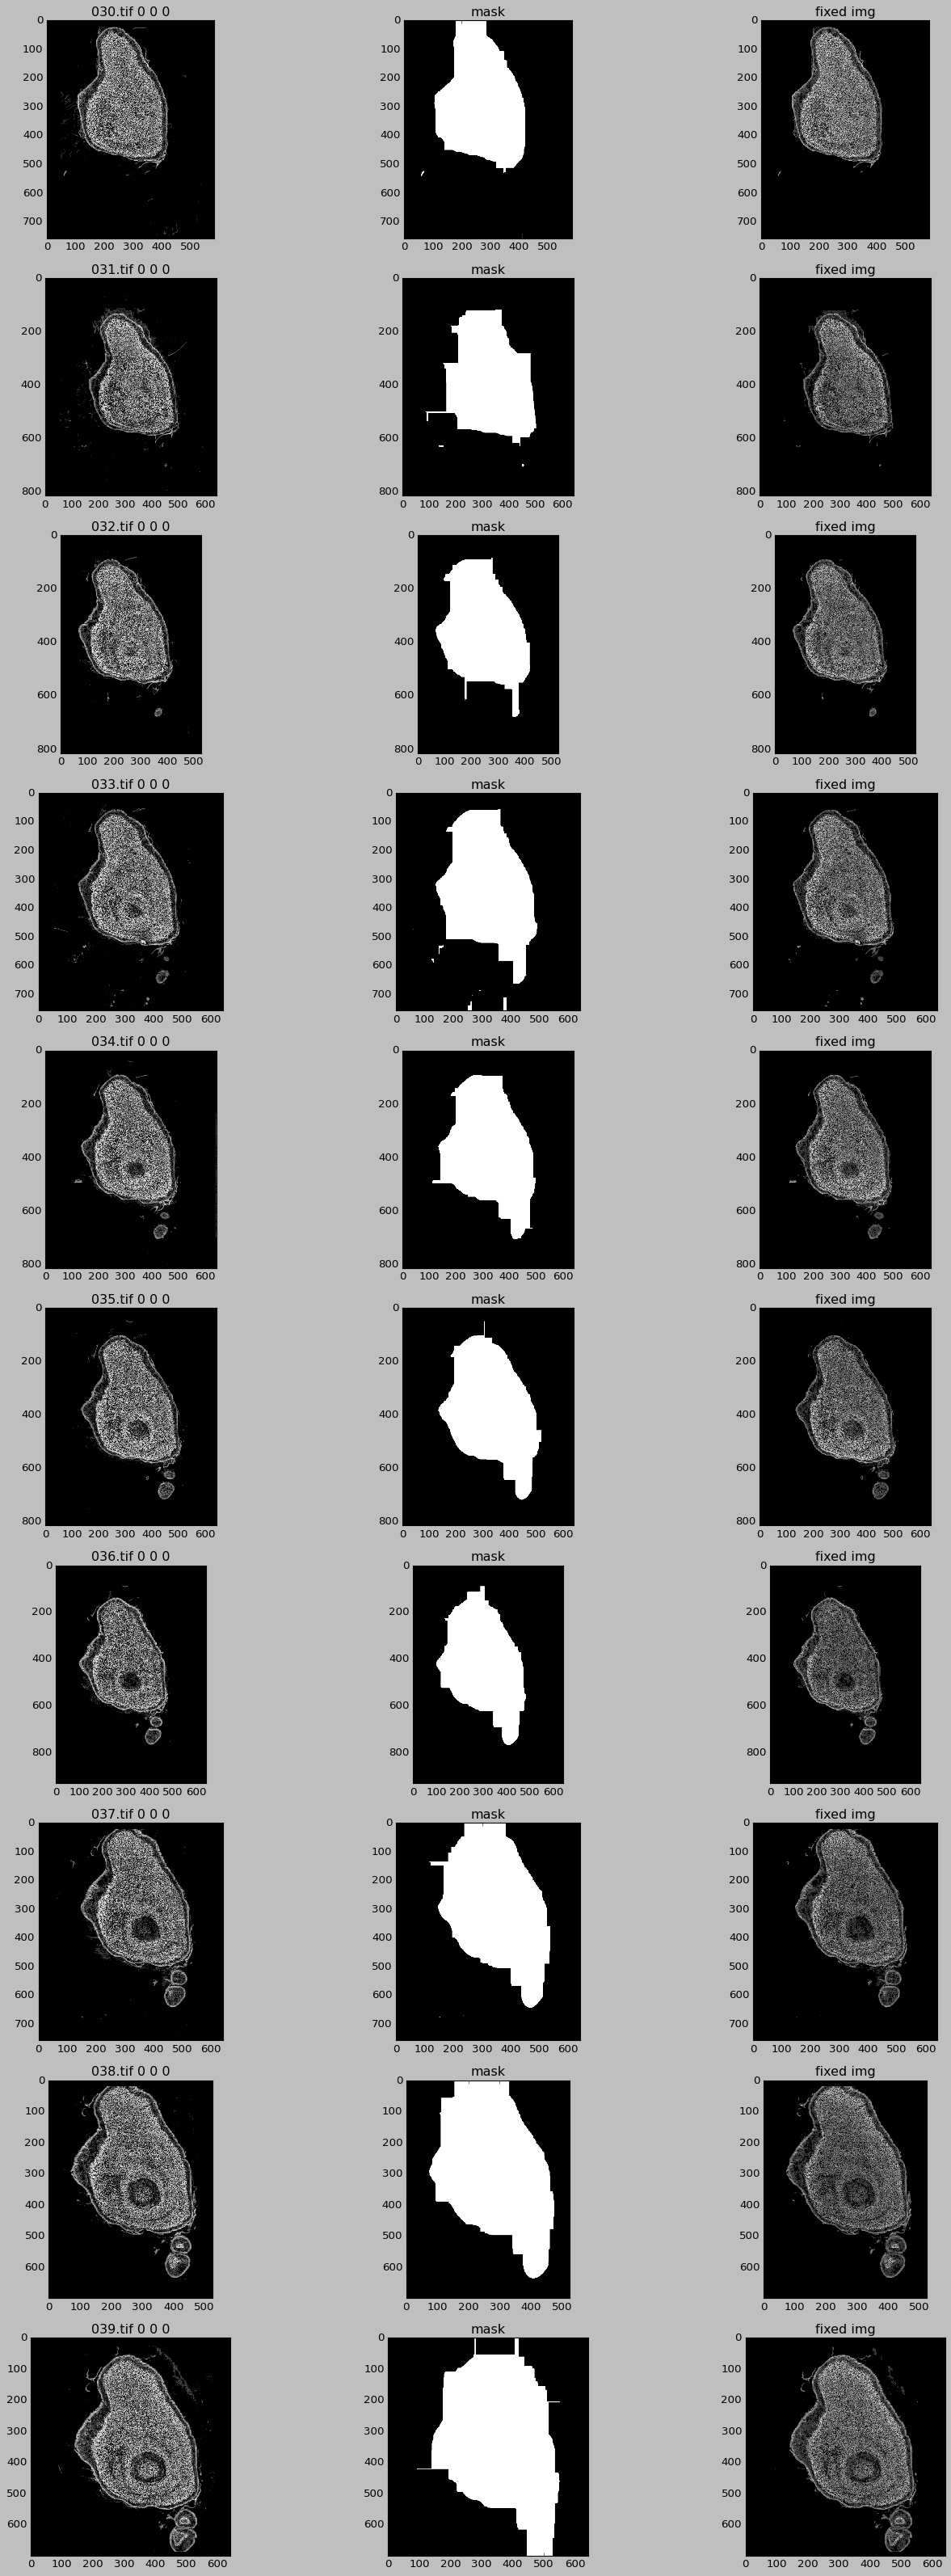

In [66]:
names = []
norms = []
masks = []
fixes = []
start, finish = (30,40)
lowVal, highVal, threshold = (0,0,0)

for file in tqdm(files[start:finish]):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    img = trim_edges(img)
    img[img < 45] = 0
    normed = equalized(img)
    norms.append(normed)
    mask = get_binary_mask(img)
    fixed = cv2.bitwise_and(img, img, mask=mask)
    masks.append(mask)    
    name = f'{file} {round(lowVal)} {round(highVal)} {round(threshold)}'
    names.append(name)
    fixes.append(fixed)
    
fig, ax = plt.subplots(nrows=len(names), ncols=3, sharex=False, sharey=False)
plt.style.use('classic')
i = 0
for name, norm, mask, fixed in zip(names, norms, masks, fixes):
    ax[i,0].set_title(f'{name}')
    ax[i,0].imshow(norm, cmap="gray")
    ax[i,1].set_title('mask')
    ax[i,1].imshow(mask, cmap="gray")
    ax[i,2].set_title('fixed img')
    ax[i,2].imshow(fixed, cmap="gray")

    i += 1
fig.set_size_inches(np.array([18, 4 * len(names)]), forward=False)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'fixed')

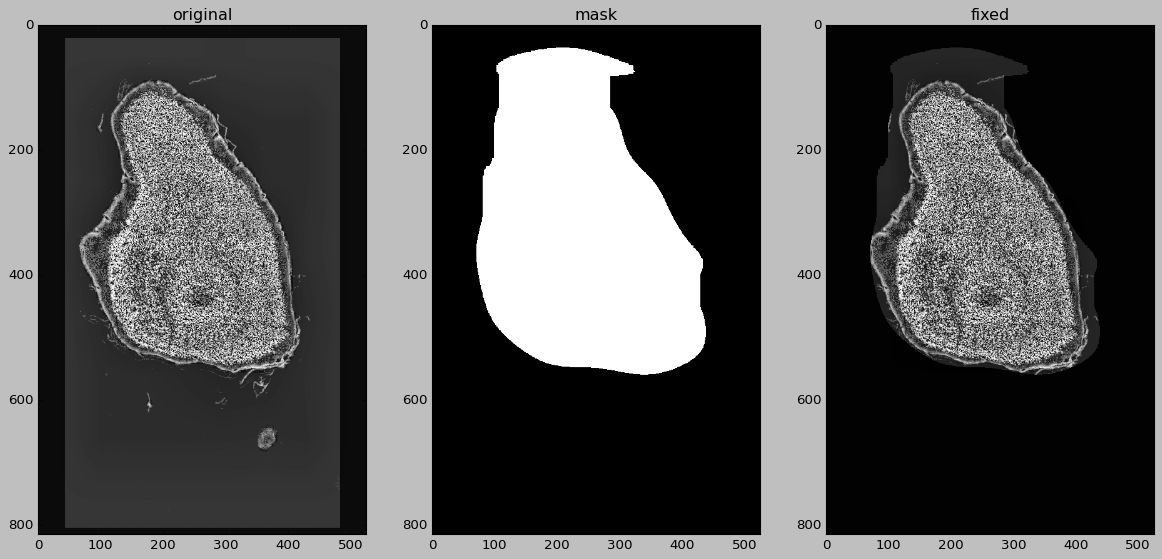

In [6]:
# 181, very dark
# 381, kinda light
file = '032.tif' 
infile = os.path.join(INPUT, file)
img = io.imread(infile)
img = trim_edges(img)
normed = equalized(img)
mask = get_binary_mask(normed)
fixed = cv2.bitwise_and(img, img, mask=mask)
fixed = equalize_adapthist(fixed)
# figure size in inches optional
rcParams['figure.figsize'] = 18 ,18
fig, ax = plt.subplots(1,3)
ax[0].imshow(normed, cmap="gray");
ax[0].set_title('original')
ax[1].imshow(mask, cmap="gray");
ax[1].set_title('mask')
ax[2].imshow(fixed, cmap="gray");
ax[2].set_title('fixed')
